In [1]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

## Explain:
So, we have to predict the DissolvedOxygen. To do so, we have to take 2 day slots and predict the goal for next 6 hours. we have 2 sites (A and B) and each site has number of devices (site A: device1 and device2, site B: device 3, device 4, device 5)

Each device has its own correlation pattern with DissolvedOxygen. So, we can devide the data to different devices and foreach decive compute the goal.

Also, we observed that there are missing data (sometimes NAN value and sometimes missing hourly data for some devices). We saw that days 23 and 24 have complete data for each devices and we can use these two days.

We will use Several models to predict the goal. The RMSE score is then demonstrated to evalute each model.

In [12]:
# The functions

# evaluate one or more hourly (6hours) forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each hour
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# prepare a list of machine learning models
def get_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['lars'] = Lars()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['ranscac'] = RANSACRegressor()
    models['sgd'] = SGDRegressor(max_iter=2000, tol=1e-3)
    return models

# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
    yhat_sequence = list()
    input_data = [x for x in input_x]
    for j in range(6):
        # prepare the input data
        X = array(input_data[-n_input:]).reshape(1, n_input)
        # make a one-step forecast
        yhat = model.predict(X)[0]
        # add to the result
        yhat_sequence.append(yhat)
        # add the prediction to the input
        input_data.append(yhat)
    return yhat_sequence

# convert windows of 6 hours multivariate data into a series of DissolvedOxygen
def to_series(data):
    # extract just the DissolvedOxygen from each 6hours data
    series = [hours6[:, 1] for hours6 in data]
    # flatten into a single series
    series = array(series).flatten()
    return series

# convert history into inputs and outputs
def to_supervised(history, n_input):
    # convert history to a univariate series
    data = to_series(history)
    X, y = list(), list()
    ix_start = 0
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # define the end of the input sequence
        ix_end = ix_start + n_input
        # ensure we have enough data for this instance
        if ix_end < len(data):
            X.append(data[ix_start:ix_end])
            y.append(data[ix_end])
        # move along one time step
        ix_start += 1
    return array(X), array(y)

# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
    # prepare data
    train_x, train_y = to_supervised(history, n_input)
    # make pipeline
    pipeline = make_pipeline(model)
    # fit the model
    pipeline.fit(train_x, train_y)
    # predict the 6hours recursively
    yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
    return yhat_sequence

# evaluate a single model
def evaluate_model(model, train, test, n_input):
    # history is a list of 6hours data
    history = [x for x in train]
    # walk-forward validation over each 6 hours
    predictions = list()
    for i in range(len(test)):
        # predict the 6 hours
        yhat_sequence = sklearn_predict(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next 6hours
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each 6hours
    score, scores = evaluate_forecasts(test[:, :, 1], predictions)
    return score, scores, predictions

In [3]:
# load the new file
ds = read_csv('data_for_interview.csv', index_col=0)

In [4]:
ds.head()

,Datetime,WaterTemperature,DissolvedOxygen,device,site,weather_temperature,dewpoint,humidity,windspeed,winddirection
0,2020-06-15 09:00:00,22.810,98.200,device 1,site A,23.2,11.9,49,41.0,300
1,2020-06-15 11:00:00,22.910,98.460,device 1,site A,26.0,12.1,42,38.9,309
2,2020-06-15 12:00:00,22.910,NaN,device 1,site A,26.1,11.4,40,37.0,310
3,2020-06-15 14:00:00,23.365,101.585,device 1,site A,27.0,9.8,34,37.0,307
4,2020-06-15 16:00:00,23.470,NaN,device 1,site A,27.0,9.8,34,33.3,308


In [5]:
# sorting data based on Datetime
ds = ds.sort_values(by=['Datetime'])

In [6]:
# we observed that dates 23 and 24 are perfect for training our model (they have no missing data)
chosen_dates = ['2020-06-23', '2020-06-24']

###########################
Evaluation for Device 1
###########################
lr: [2.631] 0.2, 1.8, 0.5, 2.2, 3.4, 4.6
lasso: [2.525] 1.5, 0.7, 1.5, 2.8, 2.7, 4.2
ridge: [2.420] 3.2, 3.1, 0.8, 1.3, 1.8, 3.1
en: [2.526] 1.5, 0.7, 1.5, 2.8, 2.7, 4.2
huber: [3.102] 0.2, 1.1, 0.8, 3.6, 4.2, 5.0
lars: [2.631] 0.2, 1.8, 0.5, 2.2, 3.4, 4.6
llars: [2.525] 1.5, 0.7, 1.5, 2.8, 2.7, 4.2
pa: [2.168] 0.9, 2.1, 0.7, 1.3, 2.4, 3.9
ranscac: [4.736] 0.5, 5.7, 5.8, 3.5, 7.5, 0.9
sgd: [3.115] 4.3, 5.1, 3.3, 1.5, 0.9, 0.5


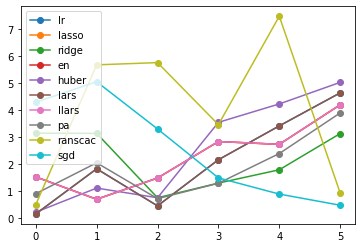

Real values: [93.55, 92.72333333333334, 90.53, 89.18, 89.28333333333335, 87.82]
Predicted values lr :  [93.38904764 90.89210633 90.07103282 91.34737329 92.70335521 92.46275662]
Predicted values lasso :  [92.02071429 92.02071429 92.02071429 92.02071429 92.02071429 92.02071429]
Predicted values ridge :  [90.39975103 89.58027058 89.77143334 90.48200958 91.07866647 90.95626883]
Predicted values en :  [92.01700512 92.02050135 92.02056237 92.02056343 92.02056345 92.02056345]
Predicted values huber :  [93.77501383 91.6057925  91.28846666 92.73146677 93.51676006 92.85155049]
Predicted values lars :  [93.38904764 90.89210633 90.07103282 91.34737329 92.70335521 92.46275662]
Predicted values llars :  [92.02071429 92.02071429 92.02071429 92.02071429 92.02071429 92.02071429]
Predicted values pa :  [92.64012433 90.67000231 89.80381343 90.47708317 91.67939327 91.71967806]
Predicted values ranscac :  [94.05650701 87.04235823 84.76686688 92.64609952 96.76353949 88.75996395]
Predicted values sgd :  [89.

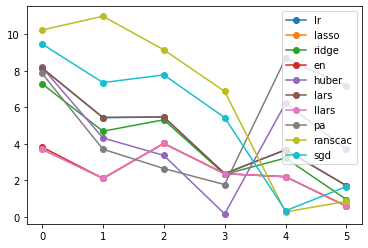

Real values: [68.04, 66.45333333333333, 68.36333333333333, 66.71000000000001, 62.13333333333333, 64.93333333333334]
Predicted values lr :  [59.88579997 61.00955639 62.89175404 64.3329508  65.8082995  66.65166253]
Predicted values lasso :  [64.33888889 64.33888889 64.33888889 64.33888889 64.33888889 64.33888889]
Predicted values ridge :  [60.75087467 61.75817379 63.04271829 64.37352219 65.36081785 65.89223835]
Predicted values en :  [64.21321102 64.33797796 64.34035462 64.34039989 64.34040075 64.34040077]
Predicted values huber :  [59.84741665 62.12889655 64.98894783 66.88065242 68.35855749 68.64030726]
Predicted values lars :  [59.88579997 61.00955639 62.89175404 64.3329508  65.8082995  66.65166253]
Predicted values llars :  [64.33888889 64.33888889 64.33888889 64.33888889 64.33888889 64.33888889]
Predicted values pa :  [60.17776379 62.74422941 65.70845058 68.48463023 70.80846237 72.11361751]
Predicted values ranscac :  [57.807254   55.46893148 59.21497359 59.83901174 61.85456425 64.07

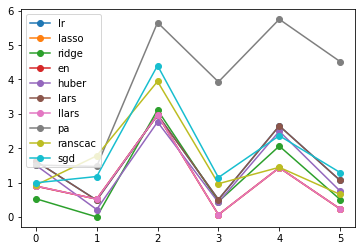

Real values: [103.14, 102.76, 99.27, 102.305, 100.80333333333334, 102.00333333333332]
Predicted values lr :  [104.76424624 103.25038633 102.24144336 102.8139025  103.45488644
 103.06638663]
Predicted values lasso :  [102.23805556 102.23805556 102.23805556 102.23805556 102.23805556
 102.23805556]
Predicted values ridge :  [103.67275226 102.75722861 102.38317425 102.75330361 102.86705839
 102.51179151]
Predicted values en :  [102.24478997 102.2381031  102.23808316 102.2380831  102.2380831
 102.2380831 ]
Predicted values huber :  [104.64741558 102.97844508 102.03412485 102.72891682 103.29817977
 102.75698545]
Predicted values lars :  [104.76424624 103.25038633 102.24144336 102.8139025  103.45488644
 103.06638663]
Predicted values llars :  [102.23805556 102.23805556 102.23805556 102.23805556 102.23805556
 102.23805556]
Predicted values pa :  [104.65161319 104.22981072 104.92584531 106.2347525  106.55535396
 106.52313056]
Predicted values ranscac :  [104.06588774 104.537665   103.21443028 1

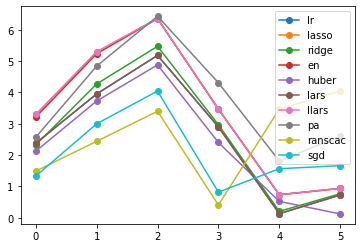

Real values: [88.79333333333334, 86.795, 85.73, 88.62, 91.355, 91.15333333333332]
Predicted values lr :  [91.17066474 90.74733006 90.91235547 91.52080607 91.2252147  91.87907452]
Predicted values lasso :  [92.08992063 92.08992063 92.08992063 92.08992063 92.08992063 92.08992063]
Predicted values ridge :  [91.11696535 91.06522245 91.20287515 91.59009389 91.55886096 91.91954962]
Predicted values en :  [92.00792236 92.03088762 92.08511066 92.08779778 92.08922468 92.08934615]
Predicted values huber :  [90.91710282 90.52017121 90.60934359 91.02192025 90.83370822 91.27551375]
Predicted values lars :  [91.17066474 90.74733006 90.91235547 91.52080607 91.2252147  91.87907452]
Predicted values llars :  [92.08992063 92.08992063 92.08992063 92.08992063 92.08992063 92.08992063]
Predicted values pa :  [91.36249364 91.63512362 92.16214556 92.92776891 93.16757204 93.75585101]
Predicted values ranscac :  [90.28156583 89.23470874 89.12926075 88.21184786 87.88742663 87.10571845]
Predicted values sgd :  [9

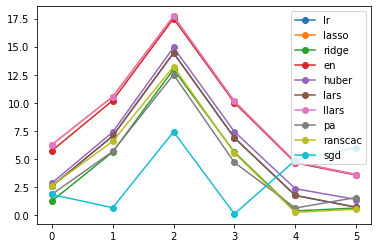

Real values: [89.98, 85.69333333333333, 78.52, 86.11333333333334, 91.525, 92.64]
Predicted values lr :  [92.5280494  92.71743823 92.96093942 92.97977598 93.25244347 93.31588002]
Predicted values lasso :  [96.23150794 96.23150794 96.23150794 96.23150794 96.23150794 96.23150794]
Predicted values ridge :  [91.19768357 91.29488853 91.49657799 91.70592379 91.87223794 92.03404289]
Predicted values en :  [95.68881938 95.88834832 96.02636988 96.11561874 96.16410124 96.1814161 ]
Predicted values huber :  [92.80578865 93.07200305 93.44770413 93.52564399 93.85422665 94.00462905]
Predicted values lars :  [92.5280494  92.71743823 92.96093942 92.97977598 93.25244347 93.31588002]
Predicted values llars :  [96.23150794 96.23150794 96.23150794 96.23150794 96.23150794 96.23150794]
Predicted values pa :  [91.79976481 91.34449856 91.02546281 90.78373677 90.91809824 91.09851812]
Predicted values ranscac :  [92.57681682 92.23654524 91.7442434  91.63391032 91.74229561 92.13749644]
Predicted values sgd :  [88

In [13]:
# for each device we do the forecasting
for i in range(1,6):
    
    # data of chosen dates
    ds_train = ds[ds['Datetime'].str.contains('|'.join(chosen_dates)) & ds['device'].str.contains(str(i))]
    ds_test = ds[ds['Datetime'].str.contains('2020-06-25') & ds['device'].str.contains(str(i))]

    
    # drop unnecessary columns
    ds_train = ds_train.drop(['Datetime','device','site'], axis=1)
    ds_test = ds_test.drop(['Datetime','device','site'], axis=1)[:6] # we need the first 6 hours
    
    # make train and test sets
    train = array(split(ds_train.values, len(ds_train.values)/6))
    test = array(split(ds_test.values, len(ds_test.values)/6))
    
    # prepare the models to evaluate
    models = get_models()
    n_input = 6
    
    # evaluate each model
    p_values = list()
    hours = ['0', '1', '2', '3', '4', '5']
    print('###########################')
    print('Evaluation for Device', i)
    print('###########################')

    for name, model in models.items():
        # evaluate and get scores
        score, scores, predictions = evaluate_model(model, train, test, n_input)
        p_values.append(predictions)
        # summarize scores
        summarize_scores(name, score, scores)
        # plot scores
        pyplot.plot(hours, scores, marker='o', label=name)
    
    # show plot
    pyplot.legend()
    pyplot.show()
    
    # printing the DissolvedOxygen values (predicted and real values)
    print('Real values:', list(test[:,:,1][0]))
    j = 0
    for name, model in models.items():
        print('Predicted values', name, ': ', str(p_values[j][0]))
        j = j + 1